In [47]:
# Dependencies
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from betacal import BetaCalibration
import ml_insights as mli
from sklearn.metrics import make_scorer, log_loss, brier_score_loss
import pandas as pd
import numpy as np

I am just going to use SVM for this example b/c it is really well known for the sigmoid-like shape it takes on for classification problems b/c it 'underneath the hood' (one of Dancho's favorite things to say! :) ) Support Vector Machines push the scores close to 0 or 1 and away from the middle so the scores get squished. Remember the algo will also come very close to 0 or 1 but because logloss will __infinitely__ punish the score if it is a 0 and it predicts a 1 and vice-versa, you also get this clumpiness. Anyway, I also choose this b/c we now know that h2o only leverages Platt, which is in essence a logit. Scikit-Learn has a cv calibration function and essentially two methods, Platt and Isotonic regression. Isotonic regression is non-parametric and can perform really well when you have loads of data but for reasons beyond the scope of this quick notebook I will leave it at that. 

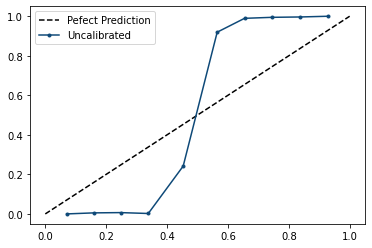

In [48]:
# Generate Binary Class Data
X, y = make_classification(n_samples=10000, n_classes=2, weights=[1,1], random_state=1)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Fit a model
uncalib_model = SVC(probability=True)
uncalib_model.fit(X_train, y_train)
uncalib_probs = uncalib_model.decision_function(X_test)

# Reliability diagram
labels = ['Pefect Prediction', 'Uncalibrated']
uncalib_fop, uncalib_mpv = calibration_curve(y_test, uncalib_probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', color="black")
plt.plot(uncalib_mpv, uncalib_fop, marker='.', color = "#0E4978")
plt.legend(labels)
plt.show()

Above we have our classic sigmoid output from our binary classification model. Now we need to get that those scores to better fit that line I wrote as perfect prediction. The y-axis for the reliability diagram here are the observed probabilities, the x-axis is the predicted probabilities from the model. When the probabilities are under that perfect line our model is over confident. For example here at just over .4 on the x-axis the actual observed is at about .2. So put plainly our model predicts something little over 40% when it actually happens at 20%. That is terrible! This is what ML models do, and they almost all suffer from this problem, which is a serious issue when you need probabilities! The opposite is true when the predicted probabilities are above the perfect prediction line. So we would say the model was underconfident. That is the observed already above 90% is only at around 55-60% for the predicted. Our model is both over confident and under-confident. Our model (in probabilistic terms) is crap! This is why we need to calibrate!

In [33]:
# Make Sure X_Train is a Pandas.DataFrame
X_train = pd.DataFrame(X_train)

# Get cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(uncalib_model, X_train, y_train, num_cv_folds=5, stratified=True, clone_model=True, random_state=123)
cv_preds_train1 = cv_preds_train[:,1]

# Platt Calibration
lr_cv = LogisticRegression(C=99999999999, solver='lbfgs')
lr_cv.fit(cv_preds_train1.reshape(-1,1), y_train)
testset_platt_probs_cv = lr_cv.predict_proba(uncalib_probs.reshape(-1,1))[:,1]

# Isotonic Calibration
iso_cv = IsotonicRegression(out_of_bounds = 'clip')
iso_cv.fit(cv_preds_train1, y_train)
testset_iso_probs_cv = iso_cv.predict(uncalib_probs)

# Beta Calibration
bc_cv = BetaCalibration()
bc_cv.fit(cv_preds_train1, y_train)
testset_bc_probs_cv = bc_cv.predict(uncalib_probs)

# Spline Calibration
splinecalib_cv = mli.SplineCalib()
splinecalib_cv.fit(cv_preds_train, y_train)
testset_splinecalib_probs_cv = splinecalib_cv.predict(uncalib_probs)

The above is how to leverage four seperate calibration techniques including ```ml-insights```'s ```SplineCalib()``` function, along with ```scikit-learn```'s ```LogisticRegression()``` function for __Platt Scaling__ and ```IsotonicRegression()``` function, as well as ```betacal```'s ```BetaCalibration()``` function. I then plot all of the result of all of the aforementioned calibration techniques and also calculate the assocated cv logloss for each. It probably goes without saying, but for the sake of completeness you would then apply the calibration technique that minimized logloss. 

*Note the stars are the binned probabilities, if you want to have a look at the associated confidence intervals associated with these simply change the error_bar parameter to 'True' to have a slightly busier, but more comprehensive look at the binned probabilities. 

*====Calibration Techniques Logloss====*
Spline CV calibrated log_loss   = 0.1031
Beta CV calibrated log_loss     = 0.2391
Isotonic CV calibrated log_loss = 0.2696
Platt CV calibrated log_loss    = 0.1403
Uncalibrated log_loss           = 0.2529
________________________________________


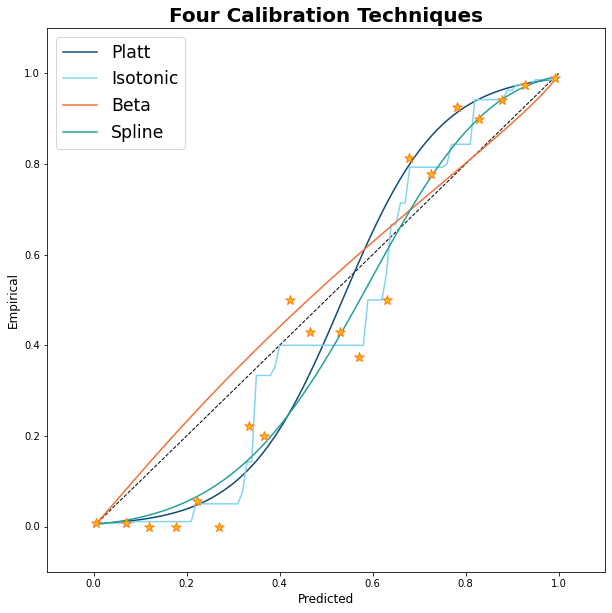

In [52]:
# Plot all Calibration Techniques
plt.figure(figsize=(10,10))
mli.plot_reliability_diagram(y_train, cv_preds_train1, marker="*", marker_color='#FFB81C', marker_size=100, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt', color = "#0E4978")
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic', color = "#83D4F1")
plt.plot(tvec, bc_cv.predict(tvec), label='Beta', color = "#F36F35")
plt.plot(tvec, splinecalib_cv.predict(tvec), label='Spline', color = "#24A097")
plt.title('Four Calibration Techniques', fontsize=20, fontweight="bold")
plt.legend(loc='upper left', fontsize='xx-large')

# Logloss Results
print('*====Calibration Techniques Logloss====*')
print('Spline CV calibrated log_loss   = {0:.4f}'.format(log_loss(y_test, testset_splinecalib_probs_cv)))
print('Beta CV calibrated log_loss     = {0:.4f}'.format(log_loss(y_test, testset_bc_probs_cv)))
print('Isotonic CV calibrated log_loss = {0:.4f}'.format(log_loss(y_test, testset_iso_probs_cv)))
print('Platt CV calibrated log_loss    = {0:.4f}'.format(log_loss(y_test, testset_platt_probs_cv)))
print('Uncalibrated log_loss           = {0:.4f}'.format(log_loss(y_test, uncalib_probs)))
print('________________________________________')